In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.optim import Optimizer
from pytorch_forecasting.models import DeepAR
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE,RMSE

In [3]:
use_col = ['volumn','datetime']
data = pd.read_csv('../traffic/data/2.csv',usecols=use_col)
# data.rename({'service_name':'group_ids','datetime':'b','volumn':'value','packets':'c','unknown':'d'},axis=1,inplace=True)
# data.drop(columns=['b','c','d'],inplace=True)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['group_ids']=np.tile('0',len(data))
data['time_idx']=np.arange(len(data))
data['value'] = data['value'] * 8 / 1000000
data['datetime'] = pd.to_datetime(data['datetime'])
data["day_of_week"] = data.datetime.dt.dayofweek.astype(str).astype("category")
data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.datetime.dt.month.astype(str).astype("category")  # categories have be strings
data['time'] = np.tile(np.arange(1440),27) #1일이 1440으로 돼있으므로
data['time'] = data['time'].astype(str).astype("category") # numpy에 astype적용시 적용이 안된다
data

/tmp/ipykernel_416574/3570259017.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings


,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,4.011808,0,0,2,30,7,0
1,2018-07-25 00:01:00,4.016080,0,1,2,30,7,1
2,2018-07-25 00:02:00,3.993376,0,2,2,30,7,2
3,2018-07-25 00:03:00,3.981656,0,3,2,30,7,3
4,2018-07-25 00:04:00,3.996736,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,7.981184,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,7.982088,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,7.980072,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,7.974312,0,38878,0,34,8,1438


<AxesSubplot: >

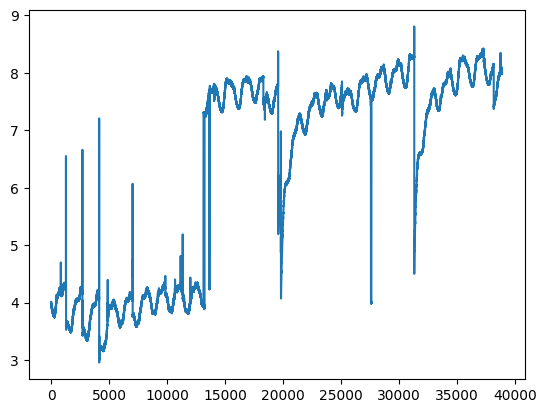

In [4]:
data['value'].plot()

In [5]:
Train_data = data.iloc[:28800]
Test_data = data.iloc[28800:]

In [6]:
encoder_length =1440
prediction_length=10080 # encoding 기간은 1일 prediction 기간은 7일

In [7]:
training = TimeSeriesDataSet(
    data=Train_data,
    max_encoder_length = encoder_length,
    min_encoder_length=1,
    max_prediction_length = prediction_length,
    min_prediction_length=1,
    target = 'value',
    group_ids = ['group_ids'],
    time_idx = 'time_idx',
    time_varying_known_categoricals=["week_of_year", "day_of_week","month","time"],
    time_varying_unknown_reals = ['value'],
    time_varying_known_reals = ['time_idx'],
    add_relative_time_idx = True,  # add as feature
    add_target_scales = True,  # add as feature
    add_encoder_length = True,  # add as feature
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True),
        'day_of_week':NaNLabelEncoder(add_nan=True),
        'month':NaNLabelEncoder(add_nan=True),
        'time':NaNLabelEncoder(add_nan=True)
    }
# NaNLableEncoder(add_nan=True)를 쓰지 않으면 새로운 categorical 변수에 대처 불가능
# https://stackoverflow.com/questions/74621525/temporal-fusion-transformer
# https://stackoverflow.com/questions/71098518/unknown-category-2-encountered-set-add-nan-true-to-allow-unknown-categories
)

In [8]:
batch_size = 64
train_dataloader = training.to_dataloader(train=False, batch_size = batch_size,num_workers = 0)

In [10]:
Train_data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,4.011808,0,0,2,30,7,0
1,2018-07-25 00:01:00,4.016080,0,1,2,30,7,1
2,2018-07-25 00:02:00,3.993376,0,2,2,30,7,2
3,2018-07-25 00:03:00,3.981656,0,3,2,30,7,3
4,2018-07-25 00:04:00,3.996736,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
28795,2018-08-13 23:55:00,7.943536,0,28795,0,33,8,1435
28796,2018-08-13 23:56:00,7.944264,0,28796,0,33,8,1436
28797,2018-08-13 23:57:00,7.940352,0,28797,0,33,8,1437
28798,2018-08-13 23:58:00,7.938736,0,28798,0,33,8,1438


In [9]:
for i,j in train_dataloader:
    print(j)

(tensor([[3.6516, 3.6531, 3.6267,  ..., 3.9332, 3.9280, 3.9290],
        [3.6531, 3.6267, 3.6240,  ..., 3.9280, 3.9290, 3.9379],
        [3.6267, 3.6240, 3.6370,  ..., 3.9290, 3.9379, 3.9615],
        ...,
        [3.5985, 3.5935, 3.5837,  ..., 3.8515, 3.8564, 3.8649],
        [3.5935, 3.5837, 3.5873,  ..., 3.8564, 3.8649, 3.8729],
        [3.5837, 3.5873, 3.5705,  ..., 3.8649, 3.8729, 3.8593]]), None)
(tensor([[3.5873, 3.5705, 3.5784,  ..., 3.8729, 3.8593, 3.8556],
        [3.5705, 3.5784, 3.5703,  ..., 3.8593, 3.8556, 3.8497],
        [3.5784, 3.5703, 3.5774,  ..., 3.8556, 3.8497, 3.8500],
        ...,
        [3.5430, 3.5653, 3.5413,  ..., 3.8536, 3.8469, 3.8509],
        [3.5653, 3.5413, 3.5395,  ..., 3.8469, 3.8509, 3.8662],
        [3.5413, 3.5395, 3.5437,  ..., 3.8509, 3.8662, 3.8601]]), None)
(tensor([[3.5395, 3.5437, 3.5453,  ..., 3.8662, 3.8601, 3.8496],
        [3.5437, 3.5453, 3.5646,  ..., 3.8601, 3.8496, 3.8507],
        [3.5453, 3.5646, 3.5522,  ..., 3.8496, 3.8507, 3.85

(tensor([[3.3598, 3.3848, 3.3660,  ..., 3.9404, 3.9405, 3.9381],
        [3.3848, 3.3660, 3.3575,  ..., 3.9405, 3.9381, 3.9508],
        [3.3660, 3.3575, 3.3585,  ..., 3.9381, 3.9508, 3.9601],
        ...,
        [3.3685, 3.3489, 3.3391,  ..., 3.9052, 3.9037, 4.0269],
        [3.3489, 3.3391, 3.3436,  ..., 3.9037, 4.0269, 7.1773],
        [3.3391, 3.3436, 3.3408,  ..., 4.0269, 7.1773, 7.2938]]), None)
(tensor([[3.3436, 3.3408, 3.3386,  ..., 7.1773, 7.2938, 7.2877],
        [3.3408, 3.3386, 3.3343,  ..., 7.2938, 7.2877, 7.2896],
        [3.3386, 3.3343, 3.3362,  ..., 7.2877, 7.2896, 7.2822],
        ...,
        [3.3826, 3.3837, 3.3829,  ..., 7.2505, 7.2485, 7.2456],
        [3.3837, 3.3829, 3.3834,  ..., 7.2485, 7.2456, 7.2447],
        [3.3829, 3.3834, 3.3852,  ..., 7.2456, 7.2447, 7.2418]]), None)
(tensor([[3.3834, 3.3852, 3.3947,  ..., 7.2447, 7.2418, 7.2435],
        [3.3852, 3.3947, 3.4202,  ..., 7.2418, 7.2435, 7.2422],
        [3.3947, 3.4202, 3.3935,  ..., 7.2435, 7.2422, 7.24

(tensor([[3.2676, 3.2925, 3.2767,  ..., 7.3145, 7.3202, 7.3181],
        [3.2925, 3.2767, 3.2681,  ..., 7.3202, 7.3181, 7.3252],
        [3.2767, 3.2681, 3.2777,  ..., 7.3181, 7.3252, 7.3332],
        ...,
        [3.3242, 3.3063, 3.3019,  ..., 7.3324, 7.3296, 7.3409],
        [3.3063, 3.3019, 3.3092,  ..., 7.3296, 7.3409, 7.3521],
        [3.3019, 3.3092, 3.3113,  ..., 7.3409, 7.3521, 7.3415]]), None)
(tensor([[3.3092, 3.3113, 3.3076,  ..., 7.3521, 7.3415, 7.3336],
        [3.3113, 3.3076, 3.3053,  ..., 7.3415, 7.3336, 7.3329],
        [3.3076, 3.3053, 3.3104,  ..., 7.3336, 7.3329, 7.3345],
        ...,
        [3.3871, 3.3898, 3.3987,  ..., 7.3960, 7.3959, 7.3978],
        [3.3898, 3.3987, 3.4003,  ..., 7.3959, 7.3978, 7.3937],
        [3.3987, 3.4003, 3.4049,  ..., 7.3978, 7.3937, 7.3986]]), None)
(tensor([[3.4003, 3.4049, 3.4197,  ..., 7.3937, 7.3986, 7.3948],
        [3.4049, 3.4197, 3.4435,  ..., 7.3986, 7.3948, 7.4032],
        [3.4197, 3.4435, 3.4190,  ..., 7.3948, 7.4032, 7.39

(tensor([[3.8584, 3.8851, 3.8738,  ..., 7.6083, 7.6096, 7.5851],
        [3.8851, 3.8738, 3.8775,  ..., 7.6096, 7.5851, 7.6114],
        [3.8738, 3.8775, 3.8540,  ..., 7.5851, 7.6114, 7.6180],
        ...,
        [3.9692, 3.9482, 3.9477,  ..., 7.7159, 7.7089, 7.7086],
        [3.9482, 3.9477, 3.9413,  ..., 7.7089, 7.7086, 7.7137],
        [3.9477, 3.9413, 3.9645,  ..., 7.7086, 7.7137, 7.7101]]), None)
(tensor([[3.9413, 3.9645, 3.9536,  ..., 7.7137, 7.7101, 7.7107],
        [3.9645, 3.9536, 3.9847,  ..., 7.7101, 7.7107, 7.7124],
        [3.9536, 3.9847, 3.9574,  ..., 7.7107, 7.7124, 7.7140],
        ...,
        [4.0075, 4.0161, 4.0349,  ..., 7.7772, 7.7994, 7.7831],
        [4.0161, 4.0349, 4.0182,  ..., 7.7994, 7.7831, 7.8052],
        [4.0349, 4.0182, 4.0125,  ..., 7.7831, 7.8052, 7.8038]]), None)
(tensor([[4.0182, 4.0125, 4.0240,  ..., 7.8052, 7.8038, 7.8241],
        [4.0125, 4.0240, 4.0159,  ..., 7.8038, 7.8241, 7.7901],
        [4.0240, 4.0159, 4.0213,  ..., 7.8241, 7.7901, 7.80

(tensor([[4.0966, 4.0918, 4.1023,  ..., 7.8977, 7.8487, 7.8697],
        [4.0918, 4.1023, 4.0944,  ..., 7.8487, 7.8697, 7.8590],
        [4.1023, 4.0944, 4.0961,  ..., 7.8697, 7.8590, 7.8692],
        ...,
        [4.0860, 4.1016, 4.0873,  ..., 7.8872, 7.8790, 7.8749],
        [4.1016, 4.0873, 4.0972,  ..., 7.8790, 7.8749, 7.8766],
        [4.0873, 4.0972, 4.0853,  ..., 7.8749, 7.8766, 7.8707]]), None)
(tensor([[4.0972, 4.0853, 4.1069,  ..., 7.8766, 7.8707, 7.8738],
        [4.0853, 4.1069, 4.1178,  ..., 7.8707, 7.8738, 7.8749],
        [4.1069, 4.1178, 4.1120,  ..., 7.8738, 7.8749, 7.8790],
        ...,
        [4.0880, 4.0908, 4.1051,  ..., 7.8955, 7.8760, 7.8942],
        [4.0908, 4.1051, 4.0837,  ..., 7.8760, 7.8942, 7.8731],
        [4.1051, 4.0837, 4.0912,  ..., 7.8942, 7.8731, 7.8953]]), None)
(tensor([[4.0837, 4.0912, 4.0883,  ..., 7.8731, 7.8953, 7.8855],
        [4.0912, 4.0883, 4.0843,  ..., 7.8953, 7.8855, 7.8915],
        [4.0883, 4.0843, 4.0688,  ..., 7.8855, 7.8915, 7.88

(tensor([[4.2029, 4.2092, 4.2269,  ..., 5.4892, 5.5128, 5.4964],
        [4.2092, 4.2269, 4.2370,  ..., 5.5128, 5.4964, 5.5155],
        [4.2269, 4.2370, 4.2258,  ..., 5.4964, 5.5155, 5.5072],
        ...,
        [4.2402, 4.2547, 4.2969,  ..., 5.7242, 5.7388, 5.7279],
        [4.2547, 4.2969, 4.2637,  ..., 5.7388, 5.7279, 5.7426],
        [4.2969, 4.2637, 4.2366,  ..., 5.7279, 5.7426, 5.7616]]), None)
(tensor([[4.2637, 4.2366, 4.2460,  ..., 5.7426, 5.7616, 5.7798],
        [4.2366, 4.2460, 4.2406,  ..., 5.7616, 5.7798, 5.7578],
        [4.2460, 4.2406, 4.2501,  ..., 5.7798, 5.7578, 5.7632],
        ...,
        [4.2877, 4.2747, 4.2813,  ..., 5.9691, 5.9917, 5.9705],
        [4.2747, 4.2813, 4.2843,  ..., 5.9917, 5.9705, 5.9774],
        [4.2813, 4.2843, 4.2918,  ..., 5.9705, 5.9774, 5.9796]]), None)
(tensor([[4.2843, 4.2918, 4.2822,  ..., 5.9774, 5.9796, 5.9910],
        [4.2918, 4.2822, 4.2921,  ..., 5.9796, 5.9910, 5.9832],
        [4.2822, 4.2921, 4.2894,  ..., 5.9910, 5.9832, 6.01

(tensor([[4.2947, 4.3061, 4.3089,  ..., 7.0752, 7.0742, 7.0625],
        [4.3061, 4.3089, 4.2942,  ..., 7.0742, 7.0625, 7.0791],
        [4.3089, 4.2942, 4.2974,  ..., 7.0625, 7.0791, 7.0552],
        ...,
        [4.8123, 4.2893, 4.2966,  ..., 7.1807, 7.1557, 7.1833],
        [4.2893, 4.2966, 4.2857,  ..., 7.1557, 7.1833, 7.1642],
        [4.2966, 4.2857, 4.3035,  ..., 7.1833, 7.1642, 7.1872]]), None)
(tensor([[4.2857, 4.3035, 4.2905,  ..., 7.1642, 7.1872, 7.1523],
        [4.3035, 4.2905, 4.5652,  ..., 7.1872, 7.1523, 7.1915],
        [4.2905, 4.5652, 4.2938,  ..., 7.1523, 7.1915, 7.1711],
        ...,
        [4.2254, 4.2297, 4.2611,  ..., 7.1904, 7.1957, 7.1992],
        [4.2297, 4.2611, 4.2341,  ..., 7.1957, 7.1992, 7.1963],
        [4.2611, 4.2341, 4.2245,  ..., 7.1992, 7.1963, 7.2010]]), None)
(tensor([[4.2341, 4.2245, 4.2197,  ..., 7.1963, 7.2010, 7.2165],
        [4.2245, 4.2197, 4.2242,  ..., 7.2010, 7.2165, 7.1903],
        [4.2197, 4.2242, 4.2097,  ..., 7.2165, 7.1903, 7.19

(tensor([[4.2580, 4.2392, 4.2516,  ..., 7.6353, 7.6295, 7.6079],
        [4.2392, 4.2516, 4.2422,  ..., 7.6295, 7.6079, 7.6149],
        [4.2516, 4.2422, 4.2560,  ..., 7.6079, 7.6149, 7.6113],
        ...,
        [4.1890, 4.1927, 4.1862,  ..., 7.5848, 7.6020, 7.5791],
        [4.1927, 4.1862, 4.1878,  ..., 7.6020, 7.5791, 7.5998],
        [4.1862, 4.1878, 4.1882,  ..., 7.5791, 7.5998, 7.5917]]), None)
(tensor([[4.1878, 4.1882, 4.2047,  ..., 7.5998, 7.5917, 7.6024],
        [4.1882, 4.2047, 4.2161,  ..., 7.5917, 7.6024, 7.5798],
        [4.2047, 4.2161, 4.2020,  ..., 7.6024, 7.5798, 7.6032],
        ...,
        [4.1622, 4.1574, 4.1699,  ..., 7.5969, 7.6074, 7.6007],
        [4.1574, 4.1699, 4.1605,  ..., 7.6074, 7.6007, 7.5932],
        [4.1699, 4.1605, 4.1545,  ..., 7.6007, 7.5932, 7.6173]]), None)
(tensor([[4.1605, 4.1545, 4.1577,  ..., 7.5932, 7.6173, 7.6374],
        [4.1545, 4.1577, 4.1641,  ..., 7.6173, 7.6374, 7.6118],
        [4.1577, 4.1641, 4.1545,  ..., 7.6374, 7.6118, 7.61

(tensor([[7.6687, 7.6532, 7.6640,  ..., 7.7601, 7.7241, 7.7360],
        [7.6532, 7.6640, 7.6465,  ..., 7.7241, 7.7360, 7.7117],
        [7.6640, 7.6465, 7.6630,  ..., 7.7360, 7.7117, 7.7233],
        ...,
        [7.6072, 7.6092, 7.6043,  ..., 7.6995, 7.7042, 7.6886],
        [7.6092, 7.6043, 7.6096,  ..., 7.7042, 7.6886, 7.6976],
        [7.6043, 7.6096, 7.6075,  ..., 7.6886, 7.6976, 7.6879]]), None)
(tensor([[7.6096, 7.6075, 7.6184,  ..., 7.6976, 7.6879, 7.6957],
        [7.6075, 7.6184, 7.6237,  ..., 7.6879, 7.6957, 7.6902],
        [7.6184, 7.6237, 7.6116,  ..., 7.6957, 7.6902, 7.6835],
        ...,
        [7.5356, 7.5350, 7.5618,  ..., 7.6156, 7.5951, 7.6084],
        [7.5350, 7.5618, 7.5333,  ..., 7.5951, 7.6084, 7.5988],
        [7.5618, 7.5333, 7.5345,  ..., 7.6084, 7.5988, 7.6146]]), None)
(tensor([[7.5333, 7.5345, 7.5187,  ..., 7.5988, 7.6146, 7.6288],
        [7.5345, 7.5187, 7.5244,  ..., 7.6146, 7.6288, 7.6140],
        [7.5187, 7.5244, 7.5124,  ..., 7.6288, 7.6140, 7.60

(tensor([[7.4808, 7.4769, 7.4848,  ..., 7.4138, 7.4162, 7.4077],
        [7.4769, 7.4848, 7.4940,  ..., 7.4162, 7.4077, 7.4112],
        [7.4848, 7.4940, 7.4854,  ..., 7.4077, 7.4112, 7.4082],
        ...,
        [7.4288, 7.4335, 7.4463,  ..., 7.3800, 7.3670, 7.3668],
        [7.4335, 7.4463, 7.4313,  ..., 7.3670, 7.3668, 7.3656],
        [7.4463, 7.4313, 7.4297,  ..., 7.3668, 7.3656, 7.3678]]), None)
(tensor([[7.4313, 7.4297, 7.4245,  ..., 7.3656, 7.3678, 7.3779],
        [7.4297, 7.4245, 7.4235,  ..., 7.3678, 7.3779, 7.3726],
        [7.4245, 7.4235, 7.4212,  ..., 7.3779, 7.3726, 7.3620],
        ...,
        [7.4058, 7.3984, 7.3960,  ..., 7.3452, 7.3664, 7.3499],
        [7.3984, 7.3960, 7.3932,  ..., 7.3664, 7.3499, 7.3497],
        [7.3960, 7.3932, 7.3954,  ..., 7.3499, 7.3497, 7.3436]]), None)
(tensor([[7.3932, 7.3954, 7.3916,  ..., 7.3497, 7.3436, 7.3486],
        [7.3954, 7.3916, 7.3941,  ..., 7.3436, 7.3486, 7.3410],
        [7.3916, 7.3941, 7.3902,  ..., 7.3486, 7.3410, 7.34

(tensor([[7.4951, 7.4855, 7.4918,  ..., 7.5231, 7.5419, 7.5546],
        [7.4855, 7.4918, 7.4854,  ..., 7.5419, 7.5546, 7.5421],
        [7.4918, 7.4854, 7.4920,  ..., 7.5546, 7.5421, 7.5333],
        ...,
        [7.5344, 7.5390, 7.5354,  ..., 7.5995, 7.6133, 7.5997],
        [7.5390, 7.5354, 7.5421,  ..., 7.6133, 7.5997, 7.5865],
        [7.5354, 7.5421, 7.5358,  ..., 7.5997, 7.5865, 7.5950]]), None)
(tensor([[7.5421, 7.5358, 7.5443,  ..., 7.5865, 7.5950, 7.5895],
        [7.5358, 7.5443, 7.5397,  ..., 7.5950, 7.5895, 7.6027],
        [7.5443, 7.5397, 7.6063,  ..., 7.5895, 7.6027, 7.5907],
        ...,
        [7.6252, 7.6234, 7.6202,  ..., 7.6626, 7.6574, 7.6695],
        [7.6234, 7.6202, 7.6604,  ..., 7.6574, 7.6695, 7.6585],
        [7.6202, 7.6604, 7.6617,  ..., 7.6695, 7.6585, 7.6710]]), None)
(tensor([[7.6604, 7.6617, 7.6400,  ..., 7.6585, 7.6710, 7.6612],
        [7.6617, 7.6400, 7.6286,  ..., 7.6710, 7.6612, 7.7018],
        [7.6400, 7.6286, 7.6294,  ..., 7.6612, 7.7018, 7.70

(tensor([[7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        ...,
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342]]), None)
(tensor([[7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        ...,
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342]]), None)
(tensor([[7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.9342],
        [7.5192, 7.5542, 7.5184,  ..., 7.9404, 7.9387, 7.93

(tensor([[7.7911, 7.7573, 7.7745,  ..., 7.9404, 7.9387, 7.9342],
        [7.7573, 7.7745, 7.7527,  ..., 7.9387, 7.9342, 0.0000],
        [7.7745, 7.7527, 7.7721,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [5.1928, 5.2078, 5.1956,  ..., 0.0000, 0.0000, 0.0000],
        [5.2078, 5.1956, 5.2048,  ..., 0.0000, 0.0000, 0.0000],
        [5.1956, 5.2048, 5.2077,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[5.2048, 5.2077, 5.2250,  ..., 7.9404, 7.9387, 7.9342],
        [5.2077, 5.2250, 5.2195,  ..., 7.9387, 7.9342, 0.0000],
        [5.2250, 5.2195, 5.2312,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [5.5128, 5.4964, 5.5155,  ..., 0.0000, 0.0000, 0.0000],
        [5.4964, 5.5155, 5.5072,  ..., 0.0000, 0.0000, 0.0000],
        [5.5155, 5.5072, 5.5320,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[5.5072, 5.5320, 5.5417,  ..., 7.9404, 7.9387, 7.9342],
        [5.5320, 5.5417, 5.5435,  ..., 7.9387, 7.9342, 0.0000],
        [5.5417, 5.5435, 5.5271,  ..., 7.9342, 0.0000, 0.00

(tensor([[6.8496, 6.8579, 6.8513,  ..., 7.9404, 7.9387, 7.9342],
        [6.8579, 6.8513, 6.8601,  ..., 7.9387, 7.9342, 0.0000],
        [6.8513, 6.8601, 6.8472,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [6.8956, 6.8991, 6.8795,  ..., 0.0000, 0.0000, 0.0000],
        [6.8991, 6.8795, 6.9058,  ..., 0.0000, 0.0000, 0.0000],
        [6.8795, 6.9058, 6.8967,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[6.9058, 6.8967, 6.9221,  ..., 7.9404, 7.9387, 7.9342],
        [6.8967, 6.9221, 6.8920,  ..., 7.9387, 7.9342, 0.0000],
        [6.9221, 6.8920, 6.9056,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [6.9614, 6.9541, 6.9526,  ..., 0.0000, 0.0000, 0.0000],
        [6.9541, 6.9526, 6.9334,  ..., 0.0000, 0.0000, 0.0000],
        [6.9526, 6.9334, 6.9374,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[6.9334, 6.9374, 6.9389,  ..., 7.9404, 7.9387, 7.9342],
        [6.9374, 6.9389, 6.9586,  ..., 7.9387, 7.9342, 0.0000],
        [6.9389, 6.9586, 6.9315,  ..., 7.9342, 0.0000, 0.00

(tensor([[7.2976, 7.2842, 7.3275,  ..., 7.9404, 7.9387, 7.9342],
        [7.2842, 7.3275, 7.2791,  ..., 7.9387, 7.9342, 0.0000],
        [7.3275, 7.2791, 7.2997,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.3750, 7.3971, 7.3650,  ..., 0.0000, 0.0000, 0.0000],
        [7.3971, 7.3650, 7.3734,  ..., 0.0000, 0.0000, 0.0000],
        [7.3650, 7.3734, 7.3666,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.3734, 7.3666, 7.3655,  ..., 7.9404, 7.9387, 7.9342],
        [7.3666, 7.3655, 7.3610,  ..., 7.9387, 7.9342, 0.0000],
        [7.3655, 7.3610, 7.3669,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.3882, 7.3955, 7.3911,  ..., 0.0000, 0.0000, 0.0000],
        [7.3955, 7.3911, 7.3970,  ..., 0.0000, 0.0000, 0.0000],
        [7.3911, 7.3970, 7.3916,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.3970, 7.3916, 7.4058,  ..., 7.9404, 7.9387, 7.9342],
        [7.3916, 7.4058, 7.4070,  ..., 7.9387, 7.9342, 0.0000],
        [7.4058, 7.4070, 7.4210,  ..., 7.9342, 0.0000, 0.00

(tensor([[7.6747, 7.6649, 7.6805,  ..., 7.9404, 7.9387, 7.9342],
        [7.6649, 7.6805, 7.6814,  ..., 7.9387, 7.9342, 0.0000],
        [7.6805, 7.6814, 7.6890,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.5508, 7.5485, 7.5554,  ..., 0.0000, 0.0000, 0.0000],
        [7.5485, 7.5554, 7.5444,  ..., 0.0000, 0.0000, 0.0000],
        [7.5554, 7.5444, 7.5560,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.5444, 7.5560, 7.5679,  ..., 7.9404, 7.9387, 7.9342],
        [7.5560, 7.5679, 7.5719,  ..., 7.9387, 7.9342, 0.0000],
        [7.5679, 7.5719, 7.5528,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.6088, 7.6176, 7.6063,  ..., 0.0000, 0.0000, 0.0000],
        [7.6176, 7.6063, 7.5769,  ..., 0.0000, 0.0000, 0.0000],
        [7.6063, 7.5769, 7.5960,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.5769, 7.5960, 7.5876,  ..., 7.9404, 7.9387, 7.9342],
        [7.5960, 7.5876, 7.6061,  ..., 7.9387, 7.9342, 0.0000],
        [7.5876, 7.6061, 7.5746,  ..., 7.9342, 0.0000, 0.00

(tensor([[7.6073, 7.5984, 7.5816,  ..., 7.9404, 7.9387, 7.9342],
        [7.5984, 7.5816, 7.5955,  ..., 7.9387, 7.9342, 0.0000],
        [7.5816, 7.5955, 7.5795,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.6398, 7.6320, 7.6294,  ..., 0.0000, 0.0000, 0.0000],
        [7.6320, 7.6294, 7.6377,  ..., 0.0000, 0.0000, 0.0000],
        [7.6294, 7.6377, 7.6184,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.6377, 7.6184, 7.6177,  ..., 7.9404, 7.9387, 7.9342],
        [7.6184, 7.6177, 7.6299,  ..., 7.9387, 7.9342, 0.0000],
        [7.6177, 7.6299, 7.6395,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.6287, 7.6401, 7.6294,  ..., 0.0000, 0.0000, 0.0000],
        [7.6401, 7.6294, 7.6478,  ..., 0.0000, 0.0000, 0.0000],
        [7.6294, 7.6478, 7.6350,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.6478, 7.6350, 7.6550,  ..., 7.9404, 7.9387, 7.9342],
        [7.6350, 7.6550, 7.6261,  ..., 7.9387, 7.9342, 0.0000],
        [7.6550, 7.6261, 7.6412,  ..., 7.9342, 0.0000, 0.00

(tensor([[7.8767, 7.8902, 7.8744,  ..., 7.9404, 7.9387, 7.9342],
        [7.8902, 7.8744, 7.8962,  ..., 7.9387, 7.9342, 0.0000],
        [7.8744, 7.8962, 7.8827,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.8932, 7.8798, 7.8877,  ..., 0.0000, 0.0000, 0.0000],
        [7.8798, 7.8877, 7.8772,  ..., 0.0000, 0.0000, 0.0000],
        [7.8877, 7.8772, 7.8843,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.8772, 7.8843, 7.8944,  ..., 7.9404, 7.9387, 7.9342],
        [7.8843, 7.8944, 7.8875,  ..., 7.9387, 7.9342, 0.0000],
        [7.8944, 7.8875, 7.8661,  ..., 7.9342, 0.0000, 0.0000],
        ...,
        [7.8674, 7.9082, 7.8727,  ..., 0.0000, 0.0000, 0.0000],
        [7.9082, 7.8727, 7.8832,  ..., 0.0000, 0.0000, 0.0000],
        [7.8727, 7.8832, 7.8745,  ..., 0.0000, 0.0000, 0.0000]]), None)
(tensor([[7.8832, 7.8745, 7.8852,  ..., 7.9404, 7.9387, 7.9342],
        [7.8745, 7.8852, 7.8680,  ..., 7.9387, 7.9342, 0.0000],
        [7.8852, 7.8680, 7.8850,  ..., 7.9342, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.8925, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8925, 3.8961, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8925, 3.8961, 3.8844]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.8265, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8265, 3.8265, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8265, 3.8265, 3.8328]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.6713, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.6713, 3.6677, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.6713, 3.6677, 3.6749]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.8159, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8159, 3.8878, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8159, 3.8878, 3.8908]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.8866, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8866, 3.8845, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.8866, 3.8845, 3.9177]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.9308, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.9308, 3.9326, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.9308, 3.9326, 3.9288]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.9106, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.9106, 3.9139, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.9106, 3.9139, 3.9210]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 3.9290, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.9290, 3.9308, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 3.9290, 3.9308, 3.9515]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 4.0286, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0286, 4.0476, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0286, 4.0476, 4.0230]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 4.0523, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0523, 4.0468, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0523, 4.0468, 4.0500]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 4.0042, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0042, 4.0026, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0042, 4.0026, 4.0140]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 4.1080, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.1080, 4.0815, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.1080, 4.0815, 4.0949]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 4.0352, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0352, 4.0232, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0352, 4.0232, 4.0027]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.0161, 3.9934, 3.9817,  ..., 4.0696, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0696, 4.0752, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 4.0696, 4.0752, 4.0951]]), None)
(tensor([[4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.0000],
        [4.0161, 3.9934, 3.9817,  ..., 0.0000, 0.0000, 0.00

(tensor([[4.2189, 4.2133, 4.2449,  ..., 4.2209, 4.2119, 4.2279],
        [4.2133, 4.2449, 4.2186,  ..., 4.2119, 4.2279, 4.2188],
        [4.2449, 4.2186, 4.2226,  ..., 4.2279, 4.2188, 4.2179],
        ...,
        [4.1909, 4.2172, 4.1957,  ..., 4.2092, 4.2045, 4.2068],
        [4.2172, 4.1957, 4.1846,  ..., 4.2045, 4.2068, 4.2161],
        [4.1957, 4.1846, 4.2065,  ..., 4.2068, 4.2161, 4.2310]]), None)
(tensor([[4.1846, 4.2065, 4.1976,  ..., 4.2161, 4.2310, 4.2181],
        [4.2065, 4.1976, 4.1934,  ..., 4.2310, 4.2181, 4.2084],
        [4.1976, 4.1934, 4.1877,  ..., 4.2181, 4.2084, 4.2165],
        ...,
        [4.1368, 4.1225, 4.1294,  ..., 4.2536, 4.2450, 4.2314],
        [4.1225, 4.1294, 4.1186,  ..., 4.2450, 4.2314, 4.2456],
        [4.1294, 4.1186, 4.1282,  ..., 4.2314, 4.2456, 4.2291]]), None)
(tensor([[4.1186, 4.1282, 4.1223,  ..., 4.2456, 4.2291, 4.2378],
        [4.1282, 4.1223, 4.1483,  ..., 4.2291, 4.2378, 4.2310],
        [4.1223, 4.1483, 4.1498,  ..., 4.2378, 4.2310, 4.24

In [17]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping
import pytorch_lightning as pl
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 5, verbose = True, mode = "min")
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
net = DeepAR.from_dataset(training,
                         rnn_layers = 2,
                         hidden_size = 16,
                         optimizer = 'adam',
                         )

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [19]:
import torch

DEVICE = torch.device("cuda:0")

net.to(DEVICE)

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {'week_of_year': {'nan': 0, '30': 1, '31': 2, '32': 3, '33': 4}, 'day_of_week': {'nan': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7}, 'month': {'nan': 0, '7': 1, '8': 2}, 'time': {'nan': 0, '0': 1, '1': 2, '10': 3, '100': 4, '1000': 5, '1001': 6, '1002': 7, '1003': 8, '1004': 9, '1005': 10, '1006': 11, '1007': 12, '1008': 13, '1009': 14, '101': 15, '1010': 16, '1011': 17, '1012': 18, '1013': 19, '1014': 20, '1015': 21, '1016': 22, '1017': 23, '1018': 24, '1019': 25, '102': 26, '1020': 27, '1021': 28, '1022': 29, '1023': 30, '1024': 31, '1025': 32, '1026': 33, '1027': 34, '1028': 35, '1029': 36, '103': 37, '1030': 38, '1031': 39, '1032': 40, '1033': 41, '1034': 42, '1035': 43, '1036': 44, '1037': 45, '1038': 46, '1039': 47, '104': 48, '1040': 49, '1041': 50, '1042': 51, '1043': 52, '1044': 53, '1

In [20]:
model=trainer.fit(net,train_dataloaders=train_dataloader)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

Finding best initial lr:  96%|█████████▌| 96/100 [00:55<00:02,  1.73it/s]
`Trainer.fit` stopped: `max_steps=96` reached.
LR finder stopped early after 96 steps due to diverging loss.


Restoring states from the checkpoint path at /hdd_1/sjlee/Paper_Project/.lr_find_45ac78be-4cdd-4432-9d55-6f922736efe3.ckpt
Restored all states from the checkpoint file at /hdd_1/sjlee/Paper_Project/.lr_find_45ac78be-4cdd-4432-9d55-6f922736efe3.ckpt

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 135 K 
3 | rnn                    | LSTM                   | 10.5 K
4 | distribution_projector | Linear                 | 34    
------------------------------------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.584     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 630/630 [04:09<00:00,  2.52it/s, loss=-1.31, v_num=70, train_loss_step=-1.39, train_loss_epoch=9.290]   

Metric train_loss improved. New best score: 15.166


Epoch 1:   0%|          | 0/630 [00:00<?, ?it/s, loss=-1.31, v_num=70, train_loss_step=-1.39, train_loss_epoch=15.20]          

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:447: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Epoch 1: 100%|██████████| 630/630 [03:20<00:00,  3.14it/s, loss=-1.86, v_num=70, train_loss_step=-1.87, train_loss_epoch=15.20]  

Metric train_loss improved by 15.588 >= min_delta = 0.01. New best score: -0.422


Epoch 2: 100%|██████████| 630/630 [04:02<00:00,  2.60it/s, loss=-2.1, v_num=70, train_loss_step=-2.11, train_loss_epoch=-.422]   

Metric train_loss improved by 0.985 >= min_delta = 0.01. New best score: -1.407


Epoch 3: 100%|██████████| 630/630 [05:04<00:00,  2.07it/s, loss=-2.28, v_num=70, train_loss_step=-2.30, train_loss_epoch=-1.41]  

Metric train_loss improved by 0.154 >= min_delta = 0.01. New best score: -1.561


Epoch 4: 100%|██████████| 630/630 [05:03<00:00,  2.08it/s, loss=-2.51, v_num=70, train_loss_step=-2.54, train_loss_epoch=-1.56]  

Metric train_loss improved by 0.186 >= min_delta = 0.01. New best score: -1.747


Epoch 5: 100%|██████████| 630/630 [05:03<00:00,  2.07it/s, loss=-2.58, v_num=70, train_loss_step=-2.61, train_loss_epoch=-1.75] 

Metric train_loss improved by 0.092 >= min_delta = 0.01. New best score: -1.839


Epoch 6: 100%|██████████| 630/630 [05:03<00:00,  2.07it/s, loss=-2.57, v_num=70, train_loss_step=-2.62, train_loss_epoch=-1.84] 

Metric train_loss improved by 0.172 >= min_delta = 0.01. New best score: -2.011


Epoch 7: 100%|██████████| 630/630 [05:02<00:00,  2.08it/s, loss=-2.57, v_num=70, train_loss_step=-2.59, train_loss_epoch=-2.01] 

Metric train_loss improved by 0.105 >= min_delta = 0.01. New best score: -2.116


Epoch 9: 100%|██████████| 630/630 [05:04<00:00,  2.07it/s, loss=-2.54, v_num=70, train_loss_step=-2.71, train_loss_epoch=-2.09]    

Metric train_loss improved by 0.177 >= min_delta = 0.01. New best score: -2.292


Epoch 11: 100%|██████████| 630/630 [05:03<00:00,  2.08it/s, loss=-2.64, v_num=70, train_loss_step=-2.72, train_loss_epoch=-2.28]  

Metric train_loss improved by 0.098 >= min_delta = 0.01. New best score: -2.390


Epoch 12: 100%|██████████| 630/630 [05:02<00:00,  2.09it/s, loss=-2.67, v_num=70, train_loss_step=-2.79, train_loss_epoch=-2.39]  

Metric train_loss improved by 0.046 >= min_delta = 0.01. New best score: -2.437


Epoch 16: 100%|██████████| 630/630 [05:03<00:00,  2.08it/s, loss=-2.59, v_num=70, train_loss_step=-2.61, train_loss_epoch=-2.16]  

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: -2.464


Epoch 17: 100%|██████████| 630/630 [05:05<00:00,  2.06it/s, loss=-2.79, v_num=70, train_loss_step=-2.87, train_loss_epoch=-2.46] 

Metric train_loss improved by 0.061 >= min_delta = 0.01. New best score: -2.525


Epoch 18: 100%|██████████| 630/630 [05:05<00:00,  2.06it/s, loss=-2.73, v_num=70, train_loss_step=-2.90, train_loss_epoch=-2.52] 

Metric train_loss improved by 0.082 >= min_delta = 0.01. New best score: -2.607


Epoch 22: 100%|██████████| 630/630 [05:02<00:00,  2.08it/s, loss=-2.67, v_num=70, train_loss_step=-2.90, train_loss_epoch=-2.54]  

Metric train_loss improved by 0.098 >= min_delta = 0.01. New best score: -2.705


Epoch 27: 100%|██████████| 630/630 [05:01<00:00,  2.09it/s, loss=-2.58, v_num=70, train_loss_step=-2.64, train_loss_epoch=-2.30]  

Monitored metric train_loss did not improve in the last 5 records. Best score: -2.705. Signaling Trainer to stop.


Epoch 27: 100%|██████████| 630/630 [05:01<00:00,  2.09it/s, loss=-2.58, v_num=70, train_loss_step=-2.64, train_loss_epoch=-2.27]


In [21]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [22]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [23]:
new_encoder_data = Train_data.iloc[-encoder_length:]
new_decoder_data = Test_data.copy()
new_decoder_data['value'] = np.tile(new_encoder_data['value'].iloc[-1],len(new_decoder_data))
new_decoder_data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
28800,2018-08-14 00:00:00,7.93416,0,28800,1,33,8,0
28801,2018-08-14 00:01:00,7.93416,0,28801,1,33,8,1
28802,2018-08-14 00:02:00,7.93416,0,28802,1,33,8,2
28803,2018-08-14 00:03:00,7.93416,0,28803,1,33,8,3
28804,2018-08-14 00:04:00,7.93416,0,28804,1,33,8,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,7.93416,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,7.93416,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,7.93416,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,7.93416,0,38878,0,34,8,1438


In [24]:
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_raw_pred=best_model.predict(new_prediction_data , mode='prediction',return_x=False)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [25]:
new_raw_pred

tensor([[7.8701, 7.8752, 7.8592,  ..., 7.7916, 7.7937, 7.7955]])

In [26]:
pred = np.array(new_raw_pred.view(-1))

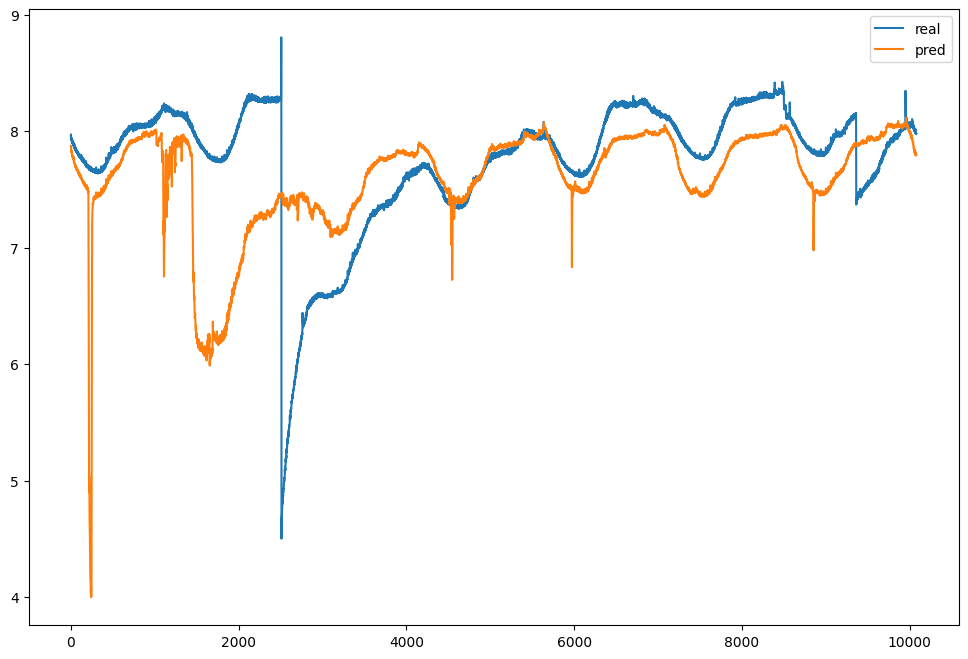

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),Test_data['value'],label='real')
axes.plot(np.arange(1,10081),pred,label='pred')
plt.legend()

In [28]:
pred

array([7.8701158, 7.875238 , 7.859173 , ..., 7.7915707, 7.7936883,
       7.79548  ], dtype=float32)

In [29]:
actuals= torch.FloatTensor(Test_data['value'].values).view(1,-1)
actuals

tensor([[7.9417, 7.9727, 7.9433,  ..., 7.9801, 7.9743, 7.9761]])

In [32]:
print('smape',SMAPE()(new_raw_pred,actuals).item()*100,'%')
print('rmse',RMSE()(new_raw_pred,actuals).item())

smape 5.566054582595825 %
rmse 0.6214982867240906


https://pycj92.tistory.com/25<br>
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/deepar.html